# Load and Train the desire testing dataset files.

In [1]:
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# data = pd.read_csv('https://ddosciu.s3.us-east-2.amazonaws.com/CSVs/UNB/Portmap.csv')
# data = pd.read_csv('https://unsw-my.sharepoint.com/:x:/r/personal/z5025758_ad_unsw_edu_au/_layouts/15/Doc.aspx?sourcedoc=%7B2A810F6A-CC3D-4D98-909E-37489D8DAF98%7D&file=UNSW_NB15_testing-set.csv&action=default&mobileredirect=true')
data = pd.read_csv("https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/Train.csv")
data.head(5)

/tmp/ipykernel_10227/4287908971.py:13: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/Train.csv")


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,13605,172.16.0.5-192.168.50.4-870-2908-17,172.16.0.5,870,192.168.50.4,2908,17,2018-11-03 10:09:00.565557,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
1,62631,172.16.0.5-192.168.50.4-871-53796-17,172.16.0.5,871,192.168.50.4,53796,17,2018-11-03 10:09:00.565559,48,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
2,143869,172.16.0.5-192.168.50.4-648-40660-17,172.16.0.5,648,192.168.50.4,40660,17,2018-11-03 10:09:00.565608,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
3,16171,172.16.0.5-192.168.50.4-872-54308-17,172.16.0.5,872,192.168.50.4,54308,17,2018-11-03 10:09:00.565993,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
4,80845,172.16.0.5-192.168.50.4-873-40653-17,172.16.0.5,873,192.168.50.4,40653,17,2018-11-03 10:09:00.565994,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS


In [2]:
set(data[' Label'])

{'BENIGN', 'LDAP', 'NetBIOS'}

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113234 entries, 0 to 2113233
Data columns (total 88 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Unnamed: 0                    int64  
 1   Flow ID                       object 
 2    Source IP                    object 
 3    Source Port                  int64  
 4    Destination IP               object 
 5    Destination Port             int64  
 6    Protocol                     int64  
 7    Timestamp                    object 
 8    Flow Duration                int64  
 9    Total Fwd Packets            int64  
 10   Total Backward Packets       int64  
 11  Total Length of Fwd Packets   float64
 12   Total Length of Bwd Packets  float64
 13   Fwd Packet Length Max        float64
 14   Fwd Packet Length Min        float64
 15   Fwd Packet Length Mean       float64
 16   Fwd Packet Length Std        float64
 17  Bwd Packet Length Max         float64
 18   Bwd Packet Length Min

Total Fwd Packets (feature 9), Total Backward Packets (feature 10), Flow Packets/s (feature 43):, Flow Bytes/s (feature 21), Protocol (feature 6): , Flow Duration (feature 8):, Packet Length Features (features 45, 46, 47, 48):, Flag Counts (features 50-57)

# Pre-process the data

In [4]:
# Encode categorical features (e.g., IP addresses)
# preparing the data for machine learning models that require numeric input features.
encoder = LabelEncoder()
data[' Source IP'] = encoder.fit_transform(data[' Source IP'])
data[' Destination IP'] = encoder.fit_transform(data[' Destination IP'])
data[' Timestamp'] = pd.to_datetime(data[' Timestamp']).astype(np.int64)
data[' Label'] = encoder.fit_transform(data[' Label'])
data.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,13605,172.16.0.5-192.168.50.4-870-2908-17,29,870,109,2908,17,1541239740565557000,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2
1,62631,172.16.0.5-192.168.50.4-871-53796-17,29,871,109,53796,17,1541239740565559000,48,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2
2,143869,172.16.0.5-192.168.50.4-648-40660-17,29,648,109,40660,17,1541239740565608000,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2
3,16171,172.16.0.5-192.168.50.4-872-54308-17,29,872,109,54308,17,1541239740565993000,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2
4,80845,172.16.0.5-192.168.50.4-873-40653-17,29,873,109,40653,17,1541239740565994000,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2


In [5]:
# Inspect the mapping between original labels and encoded numbers
# assign manual label for oringnal labels
print("Mapping between original labels and encoded numbers:")
for label, encoded_label in zip(encoder.classes_, encoder.transform(encoder.classes_)):
    print(f"{label}: {encoded_label}")

Mapping between original labels and encoded numbers:
BENIGN: 0
LDAP: 1
NetBIOS: 2


In [6]:
# Drop unnecessary columns in the CVs's
try:
  data = data.drop(['Unnamed: 0', 'Flow ID', 'SimillarHTTP'], axis=1)
  data = data.drop([' Fwd Header Length.1'], axis=1)
except:
  print('Columns are dropped already')

  # Drop unnecessary columns in the CVs's
try:
  data = data.drop([' Fwd Header Length.1'], axis=1)
except:
  print('Columns are dropped already')

Columns are dropped already


In [7]:
# Set the desired number of majority class samples
num_majority_samples = 5000 
# high number decrease the detection acuuracy 100000

# Get the minority class label
minority_class = data[' Label'].value_counts().idxmin()

# Separate majority and minority class samples
majority_samples = data[data[' Label'] != minority_class]
minority_samples = data[data[' Label'] == minority_class]

# Sample the majority class samples
majority_samples_sampled = majority_samples.sample(num_majority_samples, random_state=42)

# Combine the sampled majority class samples and minority class samples
balanced_data = pd.concat([majority_samples_sampled, minority_samples], axis=0)

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_data.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,29,856,109,51874,17,1541240780604700000,1,2,0,2944.0,...,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,1
1,29,950,109,29985,17,1541240674613821000,1,2,0,2736.0,...,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,1
2,108,53062,170,443,6,1541239745780726000,80680526,22,20,4692.0,...,68959.125,22778.281149,125332.0,60756.0,10016092.5,286607.226829,10183041.0,9455485.0,0,0
3,240,80,111,60105,6,1541240441670947000,283,1,3,6.0,...,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,0
4,29,575,109,13396,17,1541239754027348000,1,2,0,458.0,...,0.000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,2


In [8]:
num_unique_labels = balanced_data[' Label'].nunique()
print("Number of unique labels in the balanced data:", num_unique_labels)
label_frequency = balanced_data[' Label'].value_counts()
print("Frequency of each unique label in the balanced data:")
print(label_frequency)
label_frequency_data = data[' Label'].value_counts()
print("Frequency of each unique label in the original data:")
print(label_frequency_data)

Number of unique labels in the balanced data: 3
Frequency of each unique label in the balanced data:
0    5124
1    4509
2     491
Name:  Label, dtype: int64
Frequency of each unique label in the original data:
1    1905191
2     202919
0       5124
Name:  Label, dtype: int64


In [9]:
import pandas as pd

# Assuming my dataset is named 'data'
correlation = balanced_data[' Inbound'].corr(balanced_data[' Label'])
print("Correlation between 'Inbound' and 'Label':", correlation)

Correlation between 'Inbound' and 'Label': 0.7607942097746347


In [10]:
balanced_data[' Inbound'].value_counts()

1    6029
0    4095
Name:  Inbound, dtype: int64

Matplotlib is building the font cache; this may take a moment.


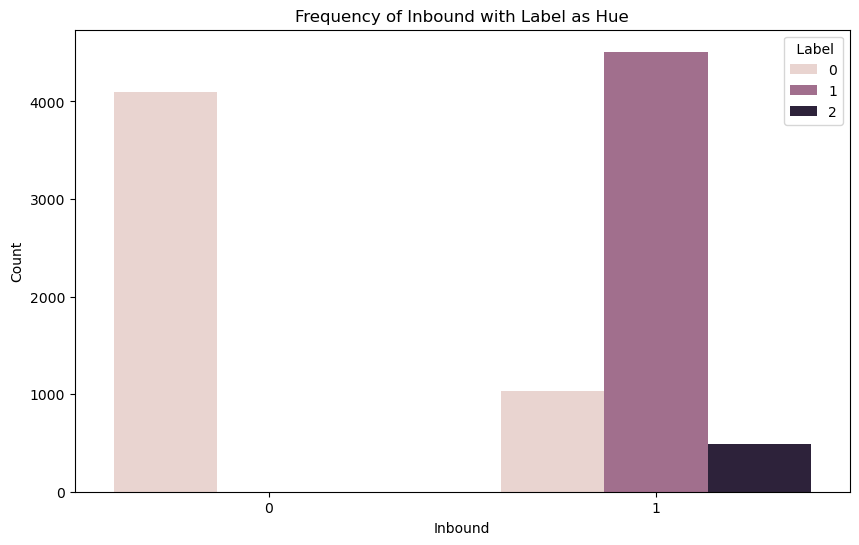

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming my dataframe is named 'df'
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_data, x=' Inbound', hue=' Label')
plt.title('Frequency of Inbound with Label as Hue')
plt.xlabel('Inbound')
plt.ylabel('Count')
plt.show()

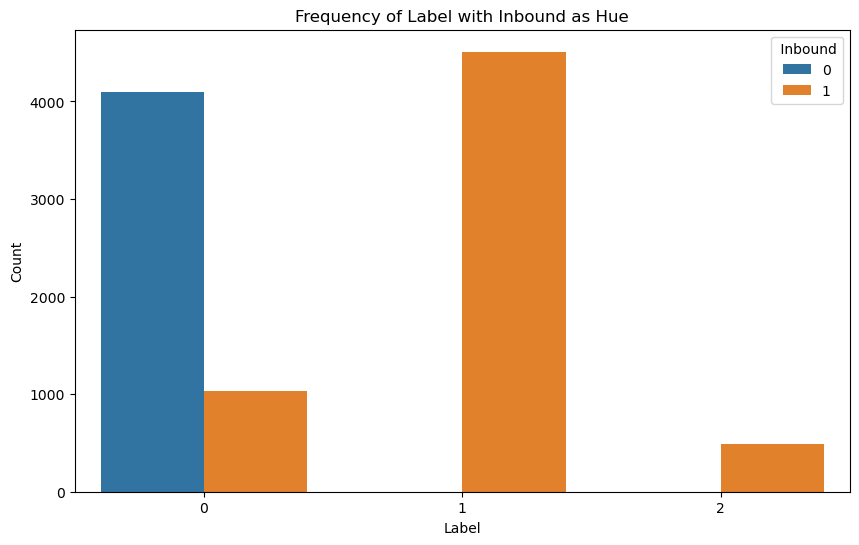

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming my dataframe is named 'df'
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_data, x=' Label', hue=' Inbound')
plt.title('Frequency of Label with Inbound as Hue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

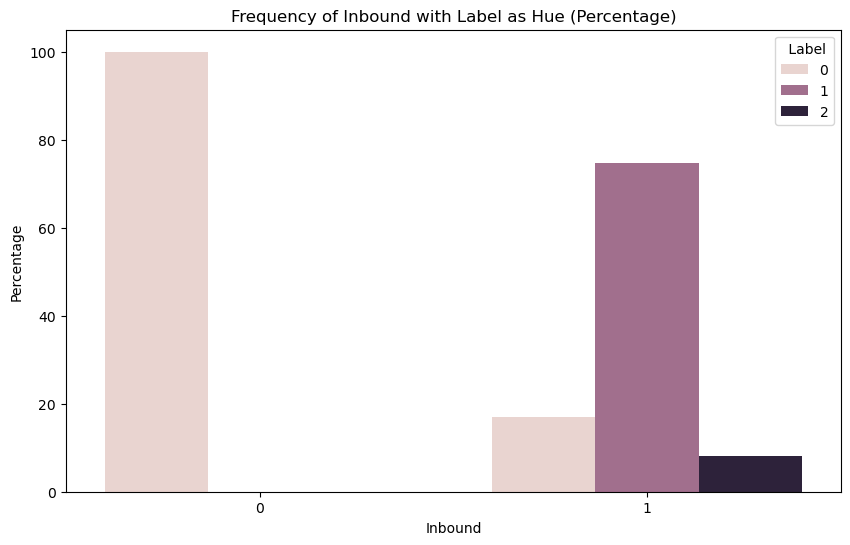

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Assuming my dataframe is named 'df'
inbound_label_counts = balanced_data.groupby([' Inbound', ' Label']).size().reset_index(name='Count')
total_counts = balanced_data.groupby([' Inbound']).size().reset_index(name='Total_Count')

inbound_label_counts = inbound_label_counts.merge(total_counts, on=' Inbound')
inbound_label_counts['Percentage'] = (inbound_label_counts['Count'] / inbound_label_counts['Total_Count']) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=inbound_label_counts, x=' Inbound', y='Percentage', hue=' Label')
plt.title('Frequency of Inbound with Label as Hue (Percentage)')
plt.xlabel('Inbound')
plt.ylabel('Percentage')
plt.show()

In [14]:
inbound_label_counts

,Inbound,Label,Count,Total_Count,Percentage
0,0,0,4095,4095,100.000000
1,1,0,1029,6029,17.067507
2,1,1,4509,6029,74.788522
3,1,2,491,6029,8.143971


In [15]:
# Split the data into train and test sets
X = balanced_data.drop([' Inbound',' Label'], axis=1)
y = balanced_data[' Label']

selected_columns = [
    ' Total Fwd Packets',
    ' Total Backward Packets',
    ' Flow Packets/s',
    'Flow Bytes/s',
    ' Protocol',
    ' Flow Duration',
    ' SYN Flag Count',
    ' RST Flag Count',
    ' PSH Flag Count',
    ' ACK Flag Count',
    ' URG Flag Count',
    ' CWE Flag Count',
    ' ECE Flag Count',
    'Fwd Packets/s',
    ' Bwd Packets/s',
    ' Min Packet Length',
    ' Max Packet Length',
    ' Packet Length Mean',
    ' Packet Length Std',
    ' Packet Length Variance'
]

# Selecting only the columns of interest
X_specific = X[selected_columns]


X_train, X_test, y_train, y_test = train_test_split(X_specific, y, test_size=0.2,stratify = y, random_state=42)

In [16]:
X_train.columns

Index([' Total Fwd Packets', ' Total Backward Packets', ' Flow Packets/s',
       'Flow Bytes/s', ' Protocol', ' Flow Duration', ' SYN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std',
       ' Packet Length Variance'],
      dtype='object')

In [17]:
X_train.isnull().sum().sum()

11

In [18]:
import numpy as np

def check_data_issues(data):
    if data.isnull().values.any():
        print("There are NaN values in the dataset.")
    # Check for infinite values
    if np.isinf(data).values.any():
        print("There are infinite values in the dataset.")
    # Check for extremely large values
    max_value = data.max().max()
    if max_value > np.finfo(np.float64).max:
        print(f"There are values too large for dtype('float64') in the dataset. Max value: {max_value}")
    # Check for extremely small values
    min_value = data.min().min()
    if min_value < np.finfo(np.float64).min:
        print(f"There are values too small for dtype('float64') in the dataset. Min value: {min_value}")

In [19]:
# Check the training and testing data for any issues
check_data_issues(X_train)
check_data_issues(X_test)

There are NaN values in the dataset.
There are infinite values in the dataset.
There are values too large for dtype('float64') in the dataset. Max value: inf
There are NaN values in the dataset.
There are infinite values in the dataset.
There are values too large for dtype('float64') in the dataset. Max value: inf


In [20]:
# Replace infinity values with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [21]:
X_train.columns
column_names =X_train.columns
column_names

Index([' Total Fwd Packets', ' Total Backward Packets', ' Flow Packets/s',
       'Flow Bytes/s', ' Protocol', ' Flow Duration', ' SYN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std',
       ' Packet Length Variance'],
      dtype='object')

In [22]:
# Impute NaN values with the mean of the corresponding column
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Now, standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
type(X_train)

numpy.ndarray

In [24]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import dump

# Create an empty DataFrame with the desired columns
model_comparison = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score"])
saved_models = {}  # Dictionary to store saved models


# Train and evaluate machine learning models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC()
}
print("X shape",X_train.shape)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the metrics to the DataFrame
    model_comparison = model_comparison._append({"Model": name, "Accuracy": accuracy, "F1 Score": f1}, ignore_index=True)

    # Save the trained model weight
    filename = f"{name}_model.joblib"
    dump(model, filename)
    saved_models[name] = filename  # Store the filename for later use in the tested DataSets

    print(f"{name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 score: {f1}")
    print(classification_report(y_test, y_pred))
    print(f"Model saved as: {filename}")
    print("\n")

display(model_comparison)

X shape (8099, 20)
Logistic Regression:
Accuracy: 0.9995061728395062
F1 score: 0.9995073057035023
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1025
           1       1.00      1.00      1.00       902
           2       0.99      1.00      0.99        98

    accuracy                           1.00      2025
   macro avg       1.00      1.00      1.00      2025
weighted avg       1.00      1.00      1.00      2025

Model saved as: Logistic Regression_model.joblib


Random Forest:
Accuracy: 1.0
F1 score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1025
           1       1.00      1.00      1.00       902
           2       1.00      1.00      1.00        98

    accuracy                           1.00      2025
   macro avg       1.00      1.00      1.00      2025
weighted avg       1.00      1.00      1.00      2025

Model saved as: Random Forest_model.joblib


S

,Model,Accuracy,F1 Score
0,Logistic Regression,0.999506,0.999507
1,Random Forest,1.000000,1.000000
2,Support Vector Machine,0.999012,0.999017


In [25]:
# Display the comparison DataFrame in the splited train data set 
model_comparison

,Model,Accuracy,F1 Score
0,Logistic Regression,0.999506,0.999507
1,Random Forest,1.000000,1.000000
2,Support Vector Machine,0.999012,0.999017


Logistic Regression:
Accuracy: 0.9995061728395062
F1 score: 0.9995073057035023
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1025
           1       1.00      1.00      1.00       902
           2       0.99      1.00      0.99        98

    accuracy                           1.00      2025
   macro avg       1.00      1.00      1.00      2025
weighted avg       1.00      1.00      1.00      2025



Random Forest:
Accuracy: 1.0
F1 score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1025
           1       1.00      1.00      1.00       902
           2       1.00      1.00      1.00        98

    accuracy                           1.00      2025
   macro avg       1.00      1.00      1.00      2025
weighted avg       1.00      1.00      1.00      2025



Support Vector Machine:
Accuracy: 0.9990123456790123
F1 score: 0.9

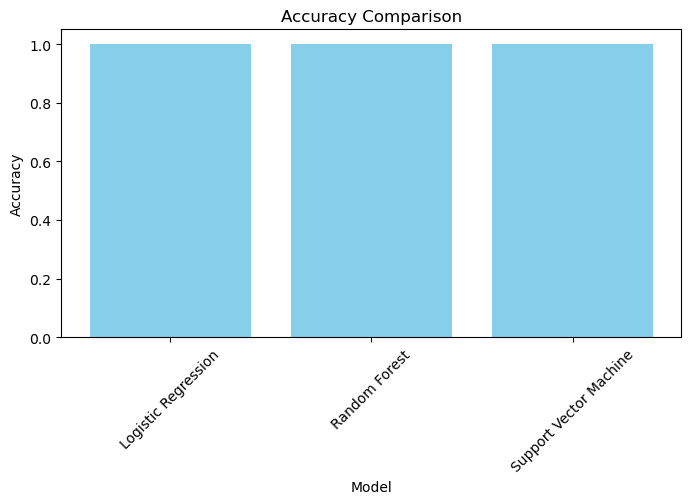

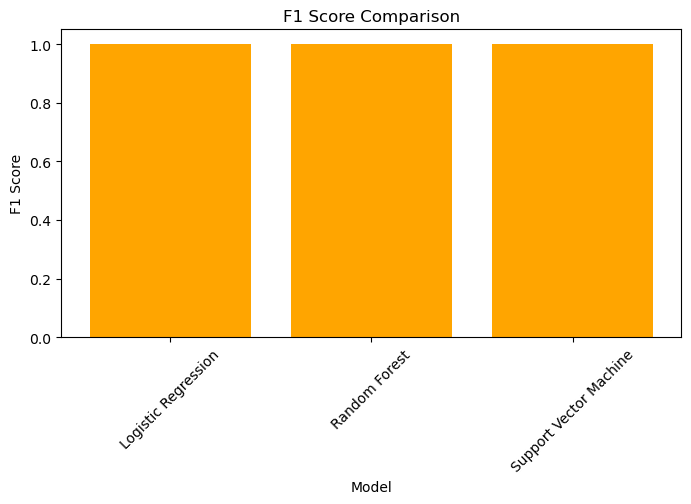

Model Comparison:
                    Model  Accuracy  F1 Score
0     Logistic Regression  0.999506  0.999507
1           Random Forest  1.000000  1.000000
2  Support Vector Machine  0.999012  0.999017


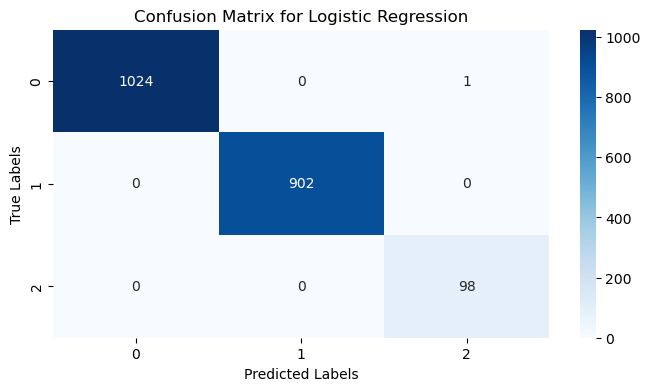

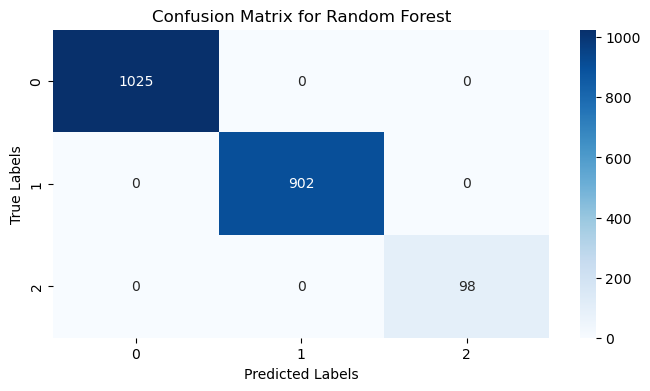

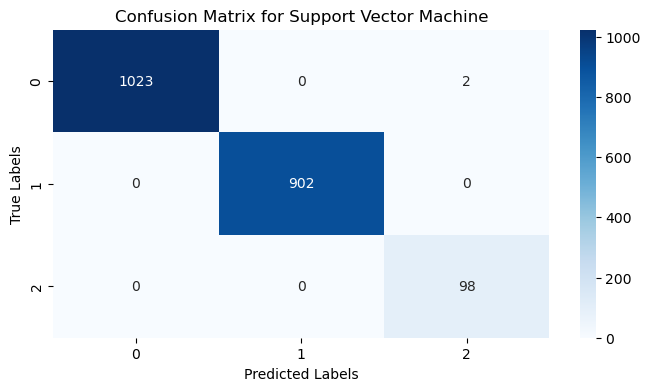

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Initialize the DataFrame to store model comparison
model_comparison = pd.DataFrame(columns=["Model", "Accuracy", "F1 Score"])

# Initialize dictionary to store confusion matrices
confusion_matrices = {}

# Initialize lists to store accuracy and F1 score for each model
accuracy_scores = []
f1_scores = []

# Iterate over each loaded model
for name, model in models.items():
    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    # Append results to model comparison DataFrame
    model_comparison = model_comparison._append({"Model": name, "Accuracy": accuracy, "F1 Score": f1}, ignore_index=True)

    # Append accuracy and F1 score to lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    # Print model evaluation metrics and confusion matrix
    print(f"{name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 score: {f1}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")

# Plotting accuracy scores
plt.figure(figsize=(8, 4))
plt.bar(model_comparison['Model'], accuracy_scores, color='skyblue')
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Plotting F1 scores
plt.figure(figsize=(8, 4))
plt.bar(model_comparison['Model'], f1_scores, color='orange')
plt.title('F1 Score Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

# Displaying the model comparison DataFrame
print("Model Comparison:")
print(model_comparison)

# Plot confusion matrices for each model using Seaborn
for name, cm in confusion_matrices.items():
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Loading Saved model weights

In [27]:
#Load the saved model
from joblib import load

# Load each model individually
# Give path of each model here
logistic_regression_model = load("Logistic Regression_model.joblib")
random_forest_model = load("Random Forest_model.joblib")
svm_model = load("Support Vector Machine_model.joblib")

# Store the loaded models in a dictionary
loaded_models = {
    "Logistic Regression": logistic_regression_model,
    "Random Forest": random_forest_model,
    "Support Vector Machine": svm_model
}

In [28]:
loaded_models.items()

dict_items([('Logistic Regression', LogisticRegression(max_iter=1000)), ('Random Forest', RandomForestClassifier()), ('Support Vector Machine', SVC())])

##Preprocessing For Testing DATA Change Title

In [29]:
feature_columns = X_specific.columns
feature_columns

Index([' Total Fwd Packets', ' Total Backward Packets', ' Flow Packets/s',
       'Flow Bytes/s', ' Protocol', ' Flow Duration', ' SYN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length',
       ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std',
       ' Packet Length Variance'],
      dtype='object')

In [30]:

# In case i dont have book.xlsx I have manually place the columns mapping here too' where keys are testing columns and values are corresponding training columns

column_mapping = {'Flow ID': 'Flow ID',
 'Src IP': ' Source IP',
 'Src Port': ' Source Port',
 'Dst IP': ' Destination IP',
 'Dst Port': ' Destination Port',
 'Protocol': ' Protocol',
 'Timestamp': ' Timestamp',
 'Flow Duration': ' Flow Duration',
 'Tot Fwd Pkts': ' Total Fwd Packets',
 'Tot Bwd Pkts': ' Total Backward Packets',
 'TotLen Fwd Pkts': 'Total Length of Fwd Packets',
 'TotLen Bwd Pkts': ' Total Length of Bwd Packets',
 'Fwd Pkt Len Max': ' Fwd Packet Length Max',
 'Fwd Pkt Len Min': ' Fwd Packet Length Min',
 'Fwd Pkt Len Mean': ' Fwd Packet Length Mean',
 'Fwd Pkt Len Std': ' Fwd Packet Length Std',
 'Bwd Pkt Len Max': 'Bwd Packet Length Max',
 'Bwd Pkt Len Min': ' Bwd Packet Length Min',
 'Bwd Pkt Len Mean': ' Bwd Packet Length Mean',
 'Bwd Pkt Len Std': ' Bwd Packet Length Std',
 'Flow Byts/s': 'Flow Bytes/s',
 'Flow Pkts/s': ' Flow Packets/s',
 'Flow IAT Mean': ' Flow IAT Mean',
 'Flow IAT Std': ' Flow IAT Std',
 'Flow IAT Max': ' Flow IAT Max',
 'Flow IAT Min': ' Flow IAT Min',
 'Fwd IAT Tot': 'Fwd IAT Total',
 'Fwd IAT Mean': ' Fwd IAT Mean',
 'Fwd IAT Std': ' Fwd IAT Std',
 'Fwd IAT Max': ' Fwd IAT Max',
 'Fwd IAT Min': ' Fwd IAT Min',
 'Bwd IAT Tot': 'Bwd IAT Total',
 'Bwd IAT Mean': ' Bwd IAT Mean',
 'Bwd IAT Std': ' Bwd IAT Std',
 'Bwd IAT Max': ' Bwd IAT Max',
 'Bwd IAT Min': ' Bwd IAT Min',
 'Fwd PSH Flags': 'Fwd PSH Flags',
 'Bwd PSH Flags': ' Bwd PSH Flags',
 'Fwd URG Flags': ' Fwd URG Flags',
 'Bwd URG Flags': ' Bwd URG Flags',
 'Fwd Header Len': ' Fwd Header Length',
 'Bwd Header Len': ' Bwd Header Length',
 'Fwd Pkts/s': 'Fwd Packets/s',
 'Bwd Pkts/s': ' Bwd Packets/s',
 'Pkt Len Min': ' Min Packet Length',
 'Pkt Len Max': ' Max Packet Length',
 'Pkt Len Mean': ' Packet Length Mean',
 'Pkt Len Std': ' Packet Length Std',
 'Pkt Len Var': ' Packet Length Variance',
 'FIN Flag Cnt': 'FIN Flag Count',
 'SYN Flag Cnt': ' SYN Flag Count',
 'RST Flag Cnt': ' RST Flag Count',
 'PSH Flag Cnt': ' PSH Flag Count',
 'ACK Flag Cnt': ' ACK Flag Count',
 'URG Flag Cnt': ' URG Flag Count',
 'CWE Flag Count': ' CWE Flag Count',
 'ECE Flag Cnt': ' ECE Flag Count',
 'Down/Up Ratio': ' Down/Up Ratio',
 'Pkt Size Avg': ' Average Packet Size',
 'Fwd Seg Size Avg': ' Avg Fwd Segment Size',
 'Bwd Seg Size Avg': ' Avg Bwd Segment Size',
 'Fwd Byts/b Avg': 'Fwd Avg Bytes/Bulk',
 'Fwd Pkts/b Avg': ' Fwd Avg Packets/Bulk',
 'Fwd Blk Rate Avg': ' Fwd Avg Bulk Rate',
 'Bwd Byts/b Avg': ' Bwd Avg Bytes/Bulk',
 'Bwd Pkts/b Avg': ' Bwd Avg Packets/Bulk',
 'Bwd Blk Rate Avg': 'Bwd Avg Bulk Rate',
 'Subflow Fwd Pkts': 'Subflow Fwd Packets',
 'Subflow Fwd Byts': ' Subflow Fwd Bytes',
 'Subflow Bwd Pkts': ' Subflow Bwd Packets',
 'Subflow Bwd Byts': ' Subflow Bwd Bytes',
 'Init Fwd Win Byts': 'Init_Win_bytes_forward',
 'Init Bwd Win Byts': ' Init_Win_bytes_backward',
 'Fwd Act Data Pkts': ' act_data_pkt_fwd',
 'Fwd Seg Size Min': ' min_seg_size_forward',
 'Active Mean': 'Active Mean',
 'Active Std': ' Active Std',
 'Active Max': ' Active Max',
 'Active Min': ' Active Min',
 'Idle Mean': 'Idle Mean',
 'Idle Std': ' Idle Std',
 'Idle Max': ' Idle Max',
 'Idle Min': ' Idle Min',
 'Label': 'Label'}

# Loading target dataset to test

In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load the new dataset am going to test the model on: i can choose only one at a moment to tst
url = "https://ddosciu.s3.us-east-2.amazonaws.com/PCAPs/Test.csv"
url1 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/HTTP_Ddos.pcap_Flow.csv"
url2 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/amp.TCP.syn.optionallyACK.optionallysamePort.pcapng_Flow.csv"
url3 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/amp.TCP.reflection.SYNACK.pcap_Flow.csv"
url4 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/amp.UDP.bacnet.IOT.37810.pcapng_Flow.csv"
url5 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/1.pcap_Flow.csv"
url6 ="https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/amp.dns.RRSIG.fragmented.pcap_Flow.csv"
url7 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/amp.UDP.isakmp.pcap_Flow.csv"
url8 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/pkt.ICMP.largeempty.pcap_Flow.csv"
url9 = "https://ddosciu.s3.us-east-2.amazonaws.com/CSV's/pkt.TCP.DOMINATE.syn.ecn.cwr.pcapng_Flow.csv"
url10 = "/content/NormalTraffic2.pcap_Flow.csv"
url11= "https://ddosciu.s3.us-east-2.amazonaws.com/IC_Taraf.root.1.pcap_Flow.csv"
url12= "https://ddosciu.s3.us-east-2.amazonaws.com/1.csv"
url13= "https://ddosciu.s3.us-east-2.amazonaws.com/21.csv"
url14 = "/content/1.csv"


new_data = pd.read_csv(url13)

# Apply the column mapping to the testing data
new_data = new_data.rename(columns=column_mapping)

In [32]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 84 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Flow ID                       9504 non-null   object 
 1    Source IP                    9504 non-null   object 
 2    Source Port                  9504 non-null   int64  
 3    Destination IP               9504 non-null   object 
 4    Destination Port             9504 non-null   int64  
 5    Protocol                     9504 non-null   int64  
 6    Timestamp                    9504 non-null   object 
 7    Flow Duration                9504 non-null   int64  
 8    Total Fwd Packets            9504 non-null   int64  
 9    Total Backward Packets       9504 non-null   int64  
 10  Total Length of Fwd Packets   9504 non-null   float64
 11   Total Length of Bwd Packets  9504 non-null   float64
 12   Fwd Packet Length Max        9504 non-null   float64
 13   Fw

In [33]:
len(X.columns),len(new_data.columns)
# Check for missing columns in new_data compared to train data X
missing_columns = set(X.columns) - set(new_data.columns)

# Check for missing columns in train data X compared to new_data
extra_columns = set(new_data.columns) - set(X.columns)

print("Columns missing in new_data:", missing_columns)
print("Columns extra in new_data:", extra_columns)

Columns missing in new_data: set()
Columns extra in new_data: {'Label', 'Flow ID'}


In [34]:
# Same Preprocessing for new dataset as i did with training dataset
# Drop irrelevant columns if necessary
columns_to_drop = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']

# Filter out columns that are not present in the DataFrame
columns_to_drop_existing = [column for column in columns_to_drop if column in new_data.columns]

# Drop the existing columns
if columns_to_drop_existing:
    new_data = new_data.drop(columns_to_drop_existing, axis=1)
else:
    print("All columns to drop are not present in the DataFrame.")


In [35]:
new_data.head(5)

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17.248.209.71,443,10.144.240.73,64077,6,12/05/2024 03:04:04 PM,808,2,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Label
1,54.195.222.162,443,10.144.180.127,55101,6,12/05/2024 03:04:04 PM,1496,1,4,34.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Label
2,10.144.181.250,62827,199.232.16.84,443,6,12/05/2024 03:04:04 PM,22,1,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Label
3,10.144.181.250,62899,50.17.2.67,443,6,12/05/2024 03:04:04 PM,45,1,1,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Label
4,193.140.13.80,443,10.144.141.103,62708,6,12/05/2024 03:04:04 PM,35469,7,6,554.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Label


In [36]:
def standardize_timestamp_format(data, column_name=' Timestamp'):
    if column_name in data.columns:
        try:
            # Trying to convert the 'Timestamp' column to datetime using the first row to infer the format
            data[column_name] = pd.to_datetime(data[column_name])
        except ValueError:
            # If ValueError occurs (e.g., due to a different format), try to parse the timestamp with multiple formats
            data[column_name] = pd.to_datetime(data[column_name], errors='coerce', format='%d/%m/%Y %I:%M:%S %p')
            data[column_name].fillna(pd.to_datetime(data[column_name], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f'), inplace=True)
    return data

# Encode categorical features
encoder = LabelEncoder()
new_data[' Source IP'] = encoder.fit_transform(new_data[' Source IP'])
new_data[' Destination IP'] = encoder.fit_transform(new_data[' Destination IP'])
# new_data[' Label'] = encoder.fit_transform(new_data[' Label'])

# Standardize the format of the 'Timestamp' column in the testing data
new_data = standardize_timestamp_format(new_data)

# Convert 'Timestamp' to datetime and then to int64
new_data[' Timestamp'] = pd.to_datetime(new_data[' Timestamp']).astype(np.int64)

In [37]:
# Define the columns to drop
columns_to_drop = ['Inbound','Label']

# Filter out columns that are not present in the DataFrame
columns_to_drop_existing = [column for column in columns_to_drop if column in new_data.columns]
# Drop the existing columns if there are any, otherwise use the original DataFrame
if columns_to_drop_existing:
    X_new = new_data.drop(columns_to_drop_existing, axis=1)
else:
    print("All columns to drop are not present in the DataFrame.")

In [38]:
X_new = X_new[X_specific.columns]

In [39]:
# Identify non-numeric columns
non_numeric_columns = X_new.select_dtypes(exclude=np.number).columns
# print("Non-numeric columns:", non_numeric_columns)

# Convert non-numeric columns to numeric format
for column in non_numeric_columns:
    X_new[column] = pd.to_numeric(X_new[column], errors='coerce')

X_new.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_new = imputer.fit_transform(X_new)
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)

#Labels for comparison (They are not always available for some datasets)
# y_new = new_data[' Label']

### Prediction

In [40]:
# Now, i can use the loaded models to make predictions on the preprocessed new dataset
predictions = {}
for name, model in loaded_models.items():
    predictions[name] = model.predict(X_new)

# Print predictions for each model
for name, preds in predictions.items():
    print(f"Predictions using {name}: {preds}")


Predictions using Logistic Regression: [2 1 2 ... 1 2 2]
Predictions using Random Forest: [0 0 0 ... 1 2 0]
Predictions using Support Vector Machine: [2 0 2 ... 1 2 2]


In [41]:
# Define a mapping from encoded labels to original labels
label_mapping = {0: 'BENIGN', 1: 'LDAP', 2: 'NetBIOS'}

# Now, i can use the loaded models to make predictions on the preprocessed new dataset
predictions = {}

# Iterate through each loaded model
for name, model in loaded_models.items():
    # Make predictions using the current model
    preds = model.predict(X_new)
    # Map encoded predictions to their original labels
    mapped_preds = [label_mapping[pred] for pred in preds]
    # Store the mapped predictions
    predictions[name] = mapped_preds

# Print mapped predictions for each model
for name, preds in predictions.items():
    print(f"Predictions using {name}: {preds}")


Predictions using Logistic Regression: ['NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'LDAP', 'LDAP', 'NetBIOS', 'LDAP', 'LDAP', 'LDAP', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'BENIGN', 'NetBIOS', 'NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'LDAP', 'NetBIOS', 'LDAP', 'NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'LDAP', 'NetBIOS', 'LDAP', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 'NetBIOS', 

In [42]:
# Initialize an empty DataFrame
all_predictions_df = pd.DataFrame()

# Initialize a list to store model names
model_names = []

# Iterate over each loaded model
for name, model in loaded_models.items():
    # Make predictions on test data
    y_pred = model.predict(X_new)

    # Map the predicted labels
    mapped_predictions = [label_mapping[label] for label in y_pred]

    # Add the model name to the list
    model_names.append(name)

    # Create a DataFrame for predicted labels
    predicted_labels_df = pd.DataFrame({'Predicted_Label': y_pred, 'Mapped_Prediction': mapped_predictions})

    # Add the DataFrame to the overall DataFrame
    all_predictions_df = pd.concat([all_predictions_df, predicted_labels_df], axis=1)

# Set the column names for the first row
all_predictions_df.columns = pd.MultiIndex.from_product([model_names, ['Predicted_Label', 'Mapped_Prediction']])

# Print the DataFrame
all_predictions_df


Logistic Regression                     Random Forest                    \
         Predicted_Label Mapped_Prediction Predicted_Label Mapped_Prediction   
0                      2           NetBIOS               0            BENIGN   
1                      1              LDAP               0            BENIGN   
2                      2           NetBIOS               0            BENIGN   
3                      2           NetBIOS               0            BENIGN   
4                      2           NetBIOS               0            BENIGN   
...                  ...               ...             ...               ...   
9499                   1              LDAP               1              LDAP   
9500                   1              LDAP               1              LDAP   
9501                   1              LDAP               1              LDAP   
9502                   2           NetBIOS               2           NetBIOS   
9503                   2           NetBIOS               0            BENIGN   

     Support Vector Machine                    
            Predicted_Label Mapped_Prediction  
0                         2           NetBIOS  
1                         0            BENIGN  
2                         2           NetBIOS  
3                         2           NetBIOS  
4                         2           NetBIOS  
...                     ...               ...  
9499                      1              LDAP  
9500                      1              LDAP  
9501                      1              LDAP  
9502                      2           NetBIOS  
9503                      2           NetBIOS  

[9504 rows x 6 columns]

In [43]:
# Define a mapping from encoded labels to original labels
label_mapping = {0: 'No Attack'}

# Now, you can use the loaded models to make predictions on the preprocessed new dataset
predictions = {}

# Iterate through each loaded model
for name, model in loaded_models.items():
    # Make predictions using the current model
    preds = model.predict(X_new)
    # Map encoded predictions to their original labels
    mapped_preds = ['No Attack' if pred == 0 else 'DDos Attack' for pred in preds]
    # Store the mapped predictions
    predictions[name] = mapped_preds

# Print mapped predictions for each model
for name, preds in predictions.items():
    print(f"Predictions using {name}: {preds}")

Predictions using Logistic Regression: ['DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'DDos Attack', 'No Attack', 'DDos Attack', 'D

In [44]:
import pandas as pd

# Initialize an empty DataFrame
all_predictions_df = pd.DataFrame()

# Initialize a list to store model names
model_names = []

# Iterate over each loaded model
for name, model in loaded_models.items():
    # Make predictions on test data
    y_pred = model.predict(X_new)

    # Map the predicted labels
    mapped_predictions = ['No Attack' if label == 0 else 'Attack' for label in y_pred]

    # Add the model name to the list
    model_names.append(name)

    # Create a DataFrame for predicted labels
    predicted_labels_df = pd.DataFrame({'Predicted_Label': y_pred, 'Mapped_Prediction': mapped_predictions})

    # Add the DataFrame to the overall DataFrame
    all_predictions_df = pd.concat([all_predictions_df, predicted_labels_df], axis=1)

# Set the column names for the first row
all_predictions_df.columns = pd.MultiIndex.from_product([model_names, ['Predicted_Label', 'Mapped_Prediction']])

# Print the DataFrame
all_predictions_df

Logistic Regression                     Random Forest                    \
         Predicted_Label Mapped_Prediction Predicted_Label Mapped_Prediction   
0                      2            Attack               0         No Attack   
1                      1            Attack               0         No Attack   
2                      2            Attack               0         No Attack   
3                      2            Attack               0         No Attack   
4                      2            Attack               0         No Attack   
...                  ...               ...             ...               ...   
9499                   1            Attack               1            Attack   
9500                   1            Attack               1            Attack   
9501                   1            Attack               1            Attack   
9502                   2            Attack               2            Attack   
9503                   2            Attack               0         No Attack   

     Support Vector Machine                    
            Predicted_Label Mapped_Prediction  
0                         2            Attack  
1                         0         No Attack  
2                         2            Attack  
3                         2            Attack  
4                         2            Attack  
...                     ...               ...  
9499                      1            Attack  
9500                      1            Attack  
9501                      1            Attack  
9502                      2            Attack  
9503                      2            Attack  

[9504 rows x 6 columns]

In [45]:
#Savinf model prediction to CSV file
all_predictions_df.to_csv('test_predictions.csv', index=False)